# CHEM277B Homework 9
### Trevor Oldham

### (A)

Process the MNIST data set into a training and test set, with one channel of 32x32 images.


In [26]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

training_set, validation_set = pd.read_pickle('mnist.pkl')

#examine the shape of the training set
print(len(training_set[0]))
print(len(training_set[0][0]))
print(len(training_set[0][0][0]))
print(len(validation_set[0]))

#normalized the training data and reshape to shape (ndata, nfeatures)
gray_img_train = np.array(training_set[0]).astype('uint8')
gray_img_train = gray_img_train.reshape(60000, 32, 32)

normalized_train_set_x = gray_img_train / 255
normalized_train_set_x = normalized_train_set_x.reshape((-1, 1, 32, 32))

print(normalized_train_set_x.shape)


gray_img_test = np.array(validation_set[0]).astype('uint8')
gray_img_test = gray_img_test.reshape(10000, 32, 32)

normalized_test_set_x = gray_img_test / 255
normalized_test_set_x = normalized_test_set_x.reshape((-1, 1, 32, 32))

print(normalized_test_set_x.shape)

train_set_y = np.array(training_set[1])
test_set_y = np.array(validation_set[1])

60000
32
32
10000
(60000, 1, 32, 32)
(10000, 1, 32, 32)


Create a pytorch model based on the specifications in the homework problem.

In [20]:
import torch
from torch import nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(1, 6, kernel_size=6, padding=2), # before pooling (B, 12, 32, 32)
                                  nn.Conv2d(6, 12, kernel_size=5, padding=2)]) # (B,24,16,16)                       
        self.pooling = nn.ModuleList([nn.MaxPool2d(kernel_size=3), nn.MaxPool2d(kernel_size=2)])
        self.fc = nn.ModuleList([nn.Linear(300,300),nn.Linear(300,10)])
        self.activation = nn.ReLU()
        self.bn = [nn.BatchNorm2d(6), nn.BatchNorm2d(12)]
        
    def forward(self, inp):
        x = self.bn[0](self.conv[0](inp))
        x = self.pooling[0](self.activation(x))
        x = self.pooling[1](self.activation(self.bn[1](self.conv[1](x))))
        x = nn.Flatten()(x)
        residual = x
        y = self.fc[0](x)
        y = y + residual
        y = self.activation(y)
        y = nn.Softmax(dim = -1)(self.fc[1](y))
        return y

In [21]:
from torchsummary import summary
model = CNN()
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 31, 31]             222
              ReLU-2            [-1, 6, 31, 31]               0
         MaxPool2d-3            [-1, 6, 10, 10]               0
            Conv2d-4           [-1, 12, 10, 10]           1,812
              ReLU-5           [-1, 12, 10, 10]               0
         MaxPool2d-6             [-1, 12, 5, 5]               0
            Linear-7                  [-1, 300]          90,300
              ReLU-8                  [-1, 300]               0
            Linear-9                   [-1, 10]           3,010
Total params: 95,344
Trainable params: 95,344
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.36
Estimated Total Size (MB): 0.49
---------------------------------------------

Create a trainer class to train the model.

In [22]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [23]:
from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split, KFold

def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x,):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform
        self.learning_rate = learning_rate


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop=False,l2=False,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to tensor of correct shape and type here ###
        inputs = torch.tensor(inputs, dtype=torch.float32)
        outputs = torch.tensor(outputs, dtype=torch.long)
        val_inputs = torch.tensor(val_inputs, dtype=torch.float32)
        val_outputs = torch.tensor(val_outputs, dtype=torch.long)
        
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = self.model.forward(batch_input)
                loss_func = nn.CrossEntropyLoss()
                loss = loss_func(batch_predictions, batch_output)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    self.optimizer = torch.optim.Adam(model.parameters(), lr = self.learning_rate, weight_decay = 1e-5)
                    loss = loss_func(batch_predictions, batch_output)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                ### Compute epoch_loss and epoch_acc
            epoch_loss, epoch_acc = self.evaluate(inputs, outputs)  
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss.detach().numpy())
            accuracies.append(epoch_acc)
            val_losses.append(val_loss.detach().numpy())
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()

        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=False):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """

        inputs = torch.tensor(inputs, dtype=torch.float32)
        outputs = torch.tensor(outputs, dtype=torch.long)

        loss_func = nn.CrossEntropyLoss()
        
        pred = self.model.forward(inputs)

        losses = loss_func(pred, outputs)
        #print("pred = ", pred)
        #print("truth = " ,outputs)
        
        sum = 0
        for i in range(len(outputs)):
          if outputs[i] == torch.argmax(pred[i]):
            sum += 1
        acc = sum / len(outputs)
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

Run the model with and without batch normalization. Which give you better test accuracy?

In [44]:
import matplotlib.pyplot as plt

def train_and_validate(model, inputs, outputs):

  total_num=len(inputs)

  model = model
  t = Trainer(model, optimizer_type='adam', learning_rate=1e-3, epoch=30, batch_size=128, input_transform=lambda x: x,)
  train_in,val_in,train_real,val_real=train_test_split(inputs,outputs, train_size = 0.666)
        
  dictionary = t.train(train_in, train_real, val_in, val_real,early_stop=True,l2=False,silent=False)

  return dictionary, model

Running the model with batch normalization:

In [45]:
model = CNN()
dictionary_1, model_1 = train_and_validate(model, normalized_train_set_x[0:10000], train_set_y[0:10000])

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-23-5a654197e45b>:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
<ipython-input-23-5a654197e45b>:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)
  3%|▎         | 1/30 [00:03<01:44,  3.61s/it]

Epoch 1/30 - Loss: 1.684 - Acc: 0.806
              Val_loss: 1.695 - Val_acc: 0.794


 37%|███▋      | 11/30 [00:43<01:14,  3.94s/it]

Epoch 11/30 - Loss: 1.478 - Acc: 0.987
              Val_loss: 1.494 - Val_acc: 0.971


 70%|███████   | 21/30 [01:23<00:37,  4.13s/it]

Epoch 21/30 - Loss: 1.469 - Acc: 0.993
              Val_loss: 1.487 - Val_acc: 0.976


func:'train'  took: 121.5386 sec


Create a new CNN model without batch normalization.


In [46]:
class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(1, 6, kernel_size=6, padding=2), # before pooling (B, 12, 32, 32)
                                  nn.Conv2d(6, 12, kernel_size=5, padding=2)]) # (B,24,16,16)                       
        self.pooling = nn.ModuleList([nn.MaxPool2d(kernel_size=3), nn.MaxPool2d(kernel_size=2)])
        self.fc = nn.ModuleList([nn.Linear(300,300),nn.Linear(300,10)])
        self.activation = nn.ReLU()
        
        
    def forward(self, inp):
        x = self.conv[0](inp)
        x = self.pooling[0](self.activation(x))
        x = self.pooling[1](self.activation(self.conv[1](x)))
        x = nn.Flatten()(x)
        residual = x
        y = self.fc[0](x)
        y = y + residual
        y = self.activation(y)
        y = nn.Softmax(dim = -1)(self.fc[1](y))
        return y

In [47]:
model = CNN_2()
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 31, 31]             222
              ReLU-2            [-1, 6, 31, 31]               0
         MaxPool2d-3            [-1, 6, 10, 10]               0
            Conv2d-4           [-1, 12, 10, 10]           1,812
              ReLU-5           [-1, 12, 10, 10]               0
         MaxPool2d-6             [-1, 12, 5, 5]               0
            Linear-7                  [-1, 300]          90,300
              ReLU-8                  [-1, 300]               0
            Linear-9                   [-1, 10]           3,010
Total params: 95,344
Trainable params: 95,344
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.36
Estimated Total Size (MB): 0.49
---------------------------------------------

In [48]:
model = CNN_2()
dictionary_2, model_2 = train_and_validate(model, normalized_train_set_x[0:10000], train_set_y[0:10000])

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-23-5a654197e45b>:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
<ipython-input-23-5a654197e45b>:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)
  3%|▎         | 1/30 [00:03<01:51,  3.84s/it]

Epoch 1/30 - Loss: 1.820 - Acc: 0.672
              Val_loss: 1.807 - Val_acc: 0.693


 37%|███▋      | 11/30 [00:34<00:58,  3.08s/it]

Epoch 11/30 - Loss: 1.582 - Acc: 0.883
              Val_loss: 1.592 - Val_acc: 0.873


 70%|███████   | 21/30 [01:07<00:28,  3.18s/it]

Epoch 21/30 - Loss: 1.487 - Acc: 0.976
              Val_loss: 1.500 - Val_acc: 0.964


func:'train'  took: 95.7824 sec


Plot the resulting Training Error and Training Accuracy

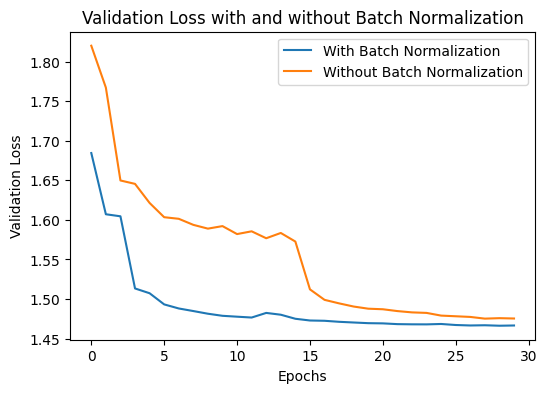

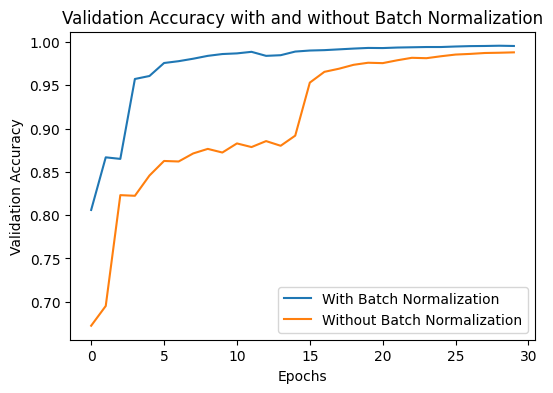

In [61]:
fig, ax = plt.subplots(1, 1, figsize=[6, 4])
losses_1 = dictionary_1['losses']
losses_1 = np.asarray(losses_1)
losses_2 = dictionary_2['losses']
losses_2 = np.asarray(losses_2)

plt.plot(np.arange(len(losses_1)),losses_1,label='With Batch Normalization')
plt.plot(np.arange(len(losses_2)), losses_2, label = 'Without Batch Normalization')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title("Validation Loss with and without Batch Normalization")
plt.legend()
plt.show()

########################

fig, ax = plt.subplots(1, 1, figsize=[6, 4])
acc_1 = dictionary_1['accuracies']
acc_1 = np.asarray(acc_1)
acc_2 = dictionary_2['accuracies']
acc_2 = np.asarray(acc_2)

plt.plot(np.arange(len(acc_1)),acc_1,label='With Batch Normalization')
plt.plot(np.arange(len(acc_2)), acc_2, label = 'Without Batch Normalization')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title("Validation Accuracy with and without Batch Normalization")
plt.legend()

The testing accuracy is best when the model is run with batch normalization enabled, and the loss is minimized faster over fewer training epochs. Both models approach a similar value for validation accuracy but the first model trains faster.

### (B)

Run the model with and without the skip connection at learning rate of 5e-3 for 10 epochs. Do you see faster training and/or better test accuracy with the skip connection?

In [64]:
### define a model with no skip connection
class CNN_3(nn.Module):
    def __init__(self):
        super(CNN_3, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(1, 6, kernel_size=6, padding=2), # before pooling (B, 12, 32, 32)
                                  nn.Conv2d(6, 12, kernel_size=5, padding=2)]) # (B,24,16,16)                       
        self.pooling = nn.ModuleList([nn.MaxPool2d(kernel_size=3), nn.MaxPool2d(kernel_size=2)])
        self.fc = nn.ModuleList([nn.Linear(300,300),nn.Linear(300,10)])
        self.activation = nn.ReLU()
        self.bn = [nn.BatchNorm2d(6), nn.BatchNorm2d(12)]
        
    def forward(self, inp):
        x = self.bn[0](self.conv[0](inp))
        x = self.pooling[0](self.activation(x))
        x = self.pooling[1](self.activation(self.bn[1](self.conv[1](x))))
        x = nn.Flatten()(x)
        
        x = self.fc[0](x)
        
        x = self.activation(x)
        x = nn.Softmax(dim = -1)(self.fc[1](x))
        return x

Define a new train and validation function with a learning rate of 5e-3 and 10 epochs.

In [67]:
def train_and_validate_2(model, inputs, outputs):

  total_num=len(inputs)

  model = model
  t = Trainer(model, optimizer_type='adam', learning_rate=5e-3, epoch=10, batch_size=128, input_transform=lambda x: x,)
  train_in,val_in,train_real,val_real=train_test_split(inputs,outputs, train_size = 0.666)
        
  dictionary = t.train(train_in, train_real, val_in, val_real,early_stop=True,l2=False,silent=False)

  return dictionary, model

Run the model without the skip connection and record the validation loss and accuracy over 10 epochs.

In [68]:
model = CNN_3()
dictionary_3, model_3 = train_and_validate_2(model, normalized_train_set_x[0:10000], train_set_y[0:10000])

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-23-5a654197e45b>:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
<ipython-input-23-5a654197e45b>:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)
 10%|█         | 1/10 [00:04<00:37,  4.14s/it]

Epoch 1/10 - Loss: 1.599 - Acc: 0.867
              Val_loss: 1.610 - Val_acc: 0.854


func:'train'  took: 40.2127 sec


Run the model with the skip connection and record the validation loss and accuracy over 10 epochs.

In [69]:
model = CNN()
dictionary_4, model_4 = train_and_validate_2(model, normalized_train_set_x[0:10000], train_set_y[0:10000])

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-23-5a654197e45b>:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
<ipython-input-23-5a654197e45b>:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)
 10%|█         | 1/10 [00:03<00:35,  3.99s/it]

Epoch 1/10 - Loss: 1.794 - Acc: 0.668
              Val_loss: 1.809 - Val_acc: 0.653


func:'train'  took: 40.2632 sec


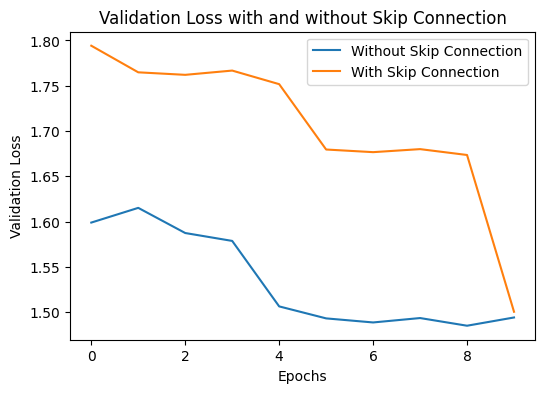

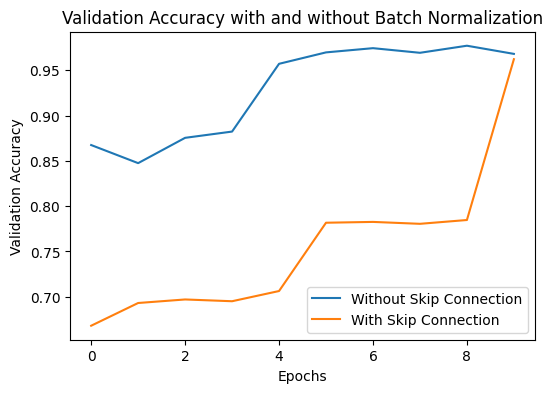

In [72]:
fig, ax = plt.subplots(1, 1, figsize=[6, 4])
losses_3 = dictionary_3['losses']
losses_3 = np.asarray(losses_3)
losses_4 = dictionary_4['losses']
losses_4 = np.asarray(losses_4)

plt.plot(np.arange(len(losses_3)),losses_3,label='Without Skip Connection')
plt.plot(np.arange(len(losses_4)), losses_4, label = 'With Skip Connection')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title("Validation Loss with and without Skip Connection")
plt.legend()
plt.show()

########################

fig, ax = plt.subplots(1, 1, figsize=[6, 4])
acc_3 = dictionary_3['accuracies']
acc_3 = np.asarray(acc_3)
acc_4 = dictionary_4['accuracies']
acc_4 = np.asarray(acc_4)

plt.plot(np.arange(len(acc_3)),acc_3,label='Without Skip Connection')
plt.plot(np.arange(len(acc_4)), acc_4, label = 'With Skip Connection')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title("Validation Accuracy with and without Batch Normalization")
plt.legend()

It seems counterintuitive but the results show that the model without a skip connection will start out with higher accuracy and lower loss, but at the point of epoch 10 the two models approach the same value. I imagine that the model with the recurrence layer will begin to perform better than the other model as the epochs increase past ten, and eventually improve to a higher accuracy as the training progresses further. We could run the model again with 30 epochs to observe if this is true.